## NLP: Using Doc2Vec to Predict Review Usefulness

In [1]:
import os
import codecs
import json
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

data_directory = os.path.join('C:/Users/andre/Documents/yelp_dataset_challenge_round9')
intermediate_directory = os.path.join(data_directory, 'intermediate')

In [2]:
df = pd.read_csv(os.path.join(intermediate_directory, 'useful.csv'))
luseful = np.log(df['useful'] + 1)

In [3]:
# Gensim's Doc2Vec class creates vector representations for entire documents
# The input object is an iterator of LineSentence objects
# The default dm=1 refers to the distributed memory algorithm
# The algorithm runs through sentences twice: (1) build the vocab, 
# (2) learn a vector representation for each word and for each label (sentence)
# Better results can be achieved by iterating over the data several times

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

doc2vec_filepath = os.path.join(intermediate_directory, 'doc2vec_model')
doc2vec = Doc2Vec.load(doc2vec_filepath)

In [4]:
print(u'{:,} terms in the word2vec vocabulary.'.format(len(doc2vec.wv.vocab)))

6,130 terms in the word2vec vocabulary.


In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
from collections import defaultdict
from tabulate import tabulate

In [6]:
def cv_rmse(model, X, y, cv=5, scoring='neg_mean_squared_error'):
    
    """ Compute an overall RMSE across all folds of cross validation"""
    
    return np.sqrt(np.mean(np.multiply(cross_val_score(
    model, X, y, cv=cv, scoring='neg_mean_squared_error'), -1)))
    
def RMSE(y_true, y_pred):
    
    """ Root Mean Squared Error"""
    
    return np.sqrt(np.mean((y_true - y_pred)**2))

def RMSLE(y_true, y_pred):
    
    """ Root Mean Squared Logarithmic Error"""
    
    return np.sqrt(np.mean(((np.log(y_true + 1) - np.log(y_pred + 1))**2)))

In [7]:
lr_d2v = Pipeline([("lr", LinearRegression())])
ridge_d2v = Pipeline([("ridge", Ridge(alpha=1))])
gbr_d2v = Pipeline([("gbr", GradientBoostingRegressor(n_estimators=100))])
rfr_d2v = Pipeline([("rfr", RandomForestRegressor(n_estimators=100))])
xgb_d2v = Pipeline([("xgb", XGBRegressor(n_estimators=100))])

In [8]:
d2v_models = [("lr_d2v", lr_d2v), ("ridge_d2v", ridge_d2v), ("gbr_d2v", gbr_d2v), 
              ("rfr_d2v", rfr_d2v), ("xgb_d2v", xgb_d2v)]

d2v_rmse = [(name, cv_rmse(model, np.array(doc2vec.docvecs), luseful, cv=5)) 
              for name, model in d2v_models]

In [9]:
print (tabulate(sorted(d2v_rmse, key=lambda x:x[1]), floatfmt=".4f", headers=("model", "RMSE_5cv")))

model        RMSE_5cv
---------  ----------
xgb_d2v        0.5850
gbr_d2v        0.5853
rfr_d2v        0.5900
ridge_d2v      0.5974
lr_d2v         0.5974


### Predicting Review Usefulness Based on the Amount of Training Data


In [10]:
def benchmark(model, X, y, n):
    ss = ShuffleSplit(n_splits=5, test_size = 1 - n, random_state=0)
    scores = []
    for train, test in ss.split(X,y):
        scores.append(RMSE(y[test], model.fit(X[train],y[train]).predict(X[test])))
    return np.mean(scores)

In [11]:
train_sizes = [0.3, 0.5, 0.7]
table = []

for name, model in d2v_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'RMSE': benchmark(model, np.array(doc2vec.docvecs), luseful, n),
                      'train_size': n})
df = pd.DataFrame(table)

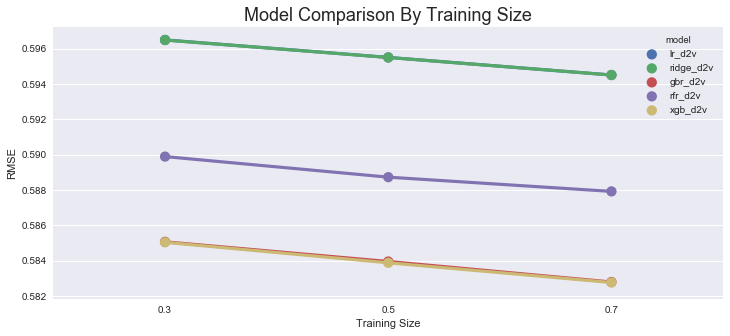

In [12]:
plt.figure(figsize=(12,5))
fig = sns.pointplot(x='train_size', y='RMSE', hue='model',
                   data=df)
sns.set_context('notebook', font_scale=1.5)
fig.set(ylabel='RMSE')
fig.set(xlabel='Training Size')
fig.set(title='Model Comparison By Training Size')
plt.show()

In [32]:
pd.pivot_table(df, values='RMSE', index='model', columns='train_size').sort_values(by=0.3)

train_size,0.3,0.5,0.7
model,,,
xgb_d2v,0.585045,0.583885,0.582770
gbr_d2v,0.585071,0.583958,0.582798
rfr_d2v,0.589895,0.588732,0.587925
ridge_d2v,0.596490,0.595505,0.594511
lr_d2v,0.596498,0.595508,0.594512
